## Fine tuning for Instruction Following 

This GPT is train to follow some instructions given an input, will work as a personal assistant.

In [1]:
import GPT
import GPTA
import torch
from torch.utils.data import DataLoader

torch.manual_seed(123)



file_path = "instruction-data.json"
url = ("https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch07/01_main-chapter-code/instruction-data.json")
data = GPTA.download_and_load_file(file_path, url)
print("Number of entries:", len(data))

Number of entries: 1100


In [2]:
# Format and visualize the input.
model_input = GPTA.format_input(data[50])
desired_response = f"\n\n### Response:\n{data[50]['output']}"
print(model_input + desired_response)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Identify the correct spelling of the following word.

### Input:
Ocassion

### Response:
The correct spelling is 'Occasion.'


## Train the model

In [3]:
train_portion = int(len(data) * 0.85)   
test_portion = int(len(data) * 0.1)          
val_portion = len(data) - train_portion - test_portion    

train_data = data[:train_portion]
test_data = data[train_portion:train_portion + test_portion]
val_data = data[train_portion + test_portion:]

print("Training set length:", len(train_data))
print("Validation set length:", len(val_data))
print("Test set length:", len(test_data))

Training set length: 935
Validation set length: 55
Test set length: 110


## Ignore Token
There is a difference between endoftext and a ignore token that is not going to be taking into account at the moment of the loss function, they are added after the first actual endoftext token. -> function input_preparation_txt()

By default, PyTorch has the cross_entropy(..., ignore_index=-100) setting to ignore examples corresponding to the label -100

In [4]:
tokenizer = GPT.create_tokenizer()
device = GPT.get_device()

In [5]:
num_workers = 0
batch_size = 1

train_dataset = GPTA.InstructionDataset(train_data, tokenizer)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    collate_fn=GPTA.input_preparation_txt,
    shuffle=True,
    drop_last=True,
    num_workers=num_workers
)
val_dataset = GPTA.InstructionDataset(val_data, tokenizer)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    collate_fn=GPTA.input_preparation_txt,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

test_dataset = GPTA.InstructionDataset(test_data, tokenizer)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    collate_fn=GPTA.input_preparation_txt,
    shuffle=False,
    drop_last=False,
    num_workers=num_workers
)

In [6]:
from gpt_download import download_and_load_gpt2


device = GPT.get_device()

# Model cunfiguration
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 1024, # context 
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": True       # Query-key-value bias
}
gpt_a = GPT.GPTModel(GPT_CONFIG_124M)
gpt_a.eval()

# Load Weights from OpenAI
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")
GPT.load_weights_into_gpt(gpt_a, params)
gpt_a.to(device)

File already exists and is up-to-date: gpt2/124M/checkpoint
File already exists and is up-to-date: gpt2/124M/encoder.json
File already exists and is up-to-date: gpt2/124M/hparams.json
File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001
File already exists and is up-to-date: gpt2/124M/model.ckpt.index
File already exists and is up-to-date: gpt2/124M/model.ckpt.meta
File already exists and is up-to-date: gpt2/124M/vocab.bpe


GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [7]:
# Behavior before the fine tuning
input_text = GPTA.format_input(val_data[0])

token_ids = GPT.text_generation(
    model=gpt_a,
    idx=GPT.text_to_token_ids(input_text, tokenizer).to(device),
    num_token_generation=30,
    top_k=30,
    temperature=1.3,
    context_size=GPT_CONFIG_124M["context_length"]
)

generated_text = GPT.token_ids_to_text(token_ids, tokenizer)
print(generated_text)

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Convert the active sentence to passive: 'The chef cooks the meal every day.'

Note The passive mode may be in multiple places: the active sentence ends while the active sentence finishes.

### Note the following instruction describes


In [8]:
# Training - Fine tuning
import time

start_time = time.time()


optimizer = torch.optim.AdamW(gpt_a.parameters(), lr=0.00005, weight_decay=0.1)

num_epochs = 3

train_losses, val_losses, tokens_seen = GPT.train_model_simple(
    gpt_a, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context=GPTA.format_input(val_data[0]), tokenizer=tokenizer
)

end_time = time.time()
execution_time_minutes = (end_time - start_time) / 60
print(f"Training completed in {execution_time_minutes:.2f} minutes.")

Ep 1 (Step 000000): Train loss 3.252, Val loss 3.354
Ep 1 (Step 000005): Train loss 1.912, Val loss 2.114
Ep 1 (Step 000010): Train loss 1.221, Val loss 1.603
Ep 1 (Step 000015): Train loss 1.467, Val loss 1.407
Ep 1 (Step 000020): Train loss 1.430, Val loss 1.304
Ep 1 (Step 000025): Train loss 0.870, Val loss 1.241
Ep 1 (Step 000030): Train loss 1.153, Val loss 1.201
Ep 1 (Step 000035): Train loss 1.321, Val loss 1.178
Ep 1 (Step 000040): Train loss 0.882, Val loss 1.143
Ep 1 (Step 000045): Train loss 1.198, Val loss 1.114
Ep 1 (Step 000050): Train loss 0.792, Val loss 1.097
Ep 1 (Step 000055): Train loss 1.078, Val loss 1.135
Ep 1 (Step 000060): Train loss 1.036, Val loss 1.151
Ep 1 (Step 000065): Train loss 0.828, Val loss 1.137
Ep 1 (Step 000070): Train loss 1.257, Val loss 1.110
Ep 1 (Step 000075): Train loss 0.702, Val loss 1.096
Ep 1 (Step 000080): Train loss 1.182, Val loss 1.098
Ep 1 (Step 000085): Train loss 1.221, Val loss 1.099
Ep 1 (Step 000090): Train loss 0.904, Val loss

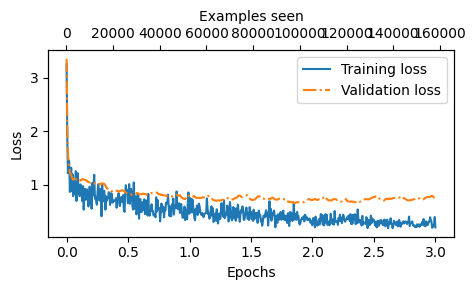

In [9]:
epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
GPT.plot_values(epochs_tensor, tokens_seen, train_losses, val_losses)

In [10]:
# Extract the response from the model
for entry in test_data[:3]:

    input_text = GPTA.format_input(entry)

    token_ids = GPT.text_generation(
        model=gpt_a,
        idx=GPT.text_to_token_ids(input_text, tokenizer).to(device),
        num_token_generation=256,
        context_size=GPT_CONFIG_124M["context_length"],
        eos_id=50256
    )
    generated_text = GPT.token_ids_to_text(token_ids, tokenizer)
    response_text = (
        generated_text[len(input_text):]
        .replace("### Response:", "")
        .strip()
    )

    print(input_text)
    print(f"\nCorrect response:\n>> {entry['output']}")
    print(f"\nModel response:\n>> {response_text.strip()}")
    print("-------------------------------------")

Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Rewrite the sentence using a simile.

### Input:
The car is very fast.

Correct response:
>> The car is as fast as lightning.

Model response:
>> The car is as fast as a bullet.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
What type of cloud is typically associated with thunderstorms?

Correct response:
>> The type of cloud typically associated with thunderstorms is cumulonimbus.

Model response:
>> The type of cloud typically associated with thunderstorms is cumulus.
-------------------------------------
Below is an instruction that describes a task. Write a response that appropriately completes the request.

### Instruction:
Name the author of 'Pride and Prejudice'.

Correct response:
>> Jane Austen.

Model response:
>> The author of 'Pride and Pr

In [11]:
torch.save(gpt_a.state_dict(), "Assistant.pth")

""" Load the model """
# model_state_dict = torch.load("Assistant.pth", map_location=device, weights_only=True)
# model.load_state_dict(model_state_dict)

' Load the model '